# Benchmarking Various Retrieval Techniques

In [152]:
import numpy as np
import json
import os
import random
import string
import time
from time import perf_counter
import numba
from numba.typed import Dict
from numba import types
from matplotlib import pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp
import asyncio

In [153]:
merch_to_ID = {}
table = {}
merch_ID = -1
temp = {}

## Helper Functions

In [154]:
# Helper Functions

def load_data():
    '''In this function we would load our data from JSON file, and if the
        file is not present we would create a new dict'''

    if(os.path.exists("table.json")):
        table = json.load(open("table.json"))
        
    if(os.path.exists("merch_to_ID.json")):
        merch_to_ID = json.load(open("merch_to_ID.json"))
        temp = dict((v,k) for k,v in merch_to_ID.items())

def insert_merchant(pincode, merchant_name):
    '''In this function we would first find out the merchant ID corresponding to the merchant name
    If the merchant name is not found, we would allot a new ID in the increasing order.
    Then we would add the ID to the pincode.
    If the pincode is not present we would add it to our table, and then add the merchant ID'''
    if(str(merchant_name) in merch_to_ID):
        merch_ID = merch_to_ID[str(merchant_name)]
        temp[merch_ID] = merchant_name
    else:
        merch_ID = len(merch_to_ID) + 1
        merch_to_ID[str(merchant_name)] = merch_ID
        temp[merch_ID] = merchant_name
    
    if((str(pincode) in table)):
        table[str(pincode)].append(merch_ID)
        table[str(pincode)] = list(set(table[str(pincode)]))
    
    else:
        table[str(pincode)] = [merch_ID]

def save_data(n):
    '''In this function, we would update our JSON files'''
    merch_to_ID = {}
    table = {}
    merch_ID = -1
    temp = {}
    delete_json()
    for j in range(n):
        insert_merchant(np.random.randint(10),''.join(random.choice(string.ascii_letters) for k in range(5)))
    
    with open("merch_to_ID.json","w") as f:
        json.dump(merch_to_ID,f)
    
    with open("table.json","w") as f:
        json.dump(table,f)

def delete_json():
    '''This function is used to delete the created json files'''
    merch_to_ID = {}
    table = {}
    temp = {}
    if(os.path.exists("table.json")):
        os.remove("table.json")
    if(os.path.exists("merch_to_ID.json")):
        os.remove("merch_to_ID.json")

## Numpy's ufunc  
In this method, we would furst convert our retrieval function into Numpy's universal function  
And then use the power of vectorization to speed up the process

In [155]:
def numpy_ufunc(pincode):
    merchants = np.frompyfunc(temp.get, 1, 1)(table[str(pincode)])
    return(list(merchants))

## list comprehension

In [156]:
def list_comprehension(pincode):
    merchants = [temp[value] for value in table[str(pincode)]]
    return(merchants)

## Asynchronous Threads
We would create multiple threads, where each thread would be responsible  
to get the merchant's ID, for the given pincode

In [157]:
def get_merchant(key):
    return temp[key]

def async_threads(pincode):
    with ThreadPoolExecutor() as executor:
        merchants = list(executor.map(lambda key: get_merchant(key), table[str(pincode)]))
    return(merchants)

## Async Multiprocessing

In [158]:
async def get(key):
    return(temp[key])

async def run(merch_IDs,index, no_of_threads):
    tasks = []
    for i in range(no_of_threads):
        tasks.append(asyncio.create_task(get(merch_IDs[i+index])))
    ans = await asyncio.gather(*tasks)
    return (ans)


def child(merch_IDs,index, no_of_threads):
    ans = asyncio.run(run(merch_IDs,index, no_of_threads))
    return (ans)


def async_multiprocessing(pincode):
    result = []
    no_of_cpu = (os. cpu_count())
    pool = mp.Pool()
    merch_IDs = table[str(pincode)]
    no_of_simulations = len(merch_IDs)
    threads_per_core = 1
    a = [pool.apply_async(child, args=(merch_IDs,i,1)) for i in range(no_of_simulations)]
    pool.close()
    pool.join()
    for i in a:
        result.append(i.get())
    # result = [x for xs in result for x in xs]
    return(result)

## Multiprocessing + Async Threading

In [159]:
def mp_thread(pincode):
    result = []
    no_of_cpu = (os. cpu_count())
    pool = mp.Pool()
    merch_IDs = table[str(pincode)]
    no_of_simulations = len(merch_IDs)
    threads_per_core = int(no_of_simulations/no_of_cpu)
    leftover_threads = no_of_simulations-(threads_per_core*no_of_cpu)
    if (no_of_simulations < no_of_cpu):
        a = pool.apply_async(child, args=(merch_IDs,0,no_of_simulations))
        pool.close()
        pool.join()
        result.append(a.get())
        return(result)
    else:
        index = np.arange(0, no_of_simulations, threads_per_core)
        a = [pool.apply_async(child, args=(merch_IDs,index[i], threads_per_core))
                for i in range(no_of_cpu)]
        pool.close()
        pool.join()
        if (leftover_threads != 0):
            pool = mp.Pool()
            b = pool.apply_async(child, args=(merch_IDs,threads_per_core*no_of_cpu,leftover_threads))
            pool.close()
            pool.join()
            result.append(b.get())
        for i in a:
            result.append(i.get())
        # result = [x for xs in result for x in xs]
        return(result)

In [160]:
# Display
delete_json()
merch_to_ID = {}
table = {}
merch_ID = -1
temp = {}
save_data(3000)
print(merch_to_ID)
print(table["1"])
print("Number of merchants serving pincode 1 ", len(table["1"]))

{'zndqB': 1, 'MAZyW': 2, 'iPocC': 3, 'eLiAy': 4, 'FmVgc': 5, 'Xtmtg': 6, 'uBhJh': 7, 'xGklJ': 8, 'UVLZE': 9, 'DApou': 10, 'NzbEH': 11, 'kDQUp': 12, 'tQPJo': 13, 'uPrTC': 14, 'kbcPj': 15, 'wXWPH': 16, 'srnUY': 17, 'sAJUy': 18, 'cglsF': 19, 'VJyOH': 20, 'rkiEe': 21, 'jrBjX': 22, 'JTPRp': 23, 'BzUFp': 24, 'Rkubw': 25, 'CEXEq': 26, 'TuYAw': 27, 'Ixmly': 28, 'jiKtH': 29, 'AVTiV': 30, 'BkRTl': 31, 'KtJzx': 32, 'pCfLQ': 33, 'pfYMi': 34, 'ZlBEm': 35, 'imQXk': 36, 'MWrFT': 37, 'vLoQl': 38, 'RyFXQ': 39, 'FKiJD': 40, 'MVvjI': 41, 'drhwT': 42, 'MYCJQ': 43, 'GXvYO': 44, 'nVyiL': 45, 'Kygfb': 46, 'aqEPx': 47, 'DnbHk': 48, 'OzalQ': 49, 'fXChk': 50, 'OwWsp': 51, 'hFnTa': 52, 'tGqSg': 53, 'HXKIC': 54, 'eFwgf': 55, 'KsDLO': 56, 'vKQfQ': 57, 'QwBcP': 58, 'lKPVf': 59, 'tVGek': 60, 'wiMER': 61, 'BNncf': 62, 'CbaOw': 63, 'oixWD': 64, 'KRSgy': 65, 'RoFXN': 66, 'UNXHy': 67, 'IajSY': 68, 'Shnob': 69, 'TZfuN': 70, 'QKiPH': 71, 'cBKbe': 72, 'azUSd': 73, 'SDLOg': 74, 'AXJln': 75, 'tjlHd': 76, 'rNDIo': 77, 'lyisE'

## Verification of all the methods

In [161]:
#Verification that all the methods work correctly or not
a = numpy_ufunc(1)
a.sort()
print(a)
a = list_comprehension(1)
a.sort()
print(a)
a = async_threads(1)
a.sort()
print(a)
a = async_multiprocessing(1)
a = [x for xs in a for x in xs]
a.sort()
print(a)
a = mp_thread(1)
a = [x for xs in a for x in xs]
a.sort()
print(a)

['ABsDk', 'AYzii', 'BUJzr', 'BWpKQ', 'BXYyq', 'BYHwg', 'BZTAu', 'BldXX', 'BpUyT', 'CEJFI', 'CesXz', 'CgsGq', 'Ciokr', 'CrDPP', 'DHOiL', 'DIYPe', 'DJnsl', 'DMBpV', 'DVhZt', 'DWdPl', 'DcQHe', 'DfSAy', 'EXGuM', 'EtcyJ', 'EvlLw', 'FTkzG', 'FZqkS', 'FmdKw', 'GmKmY', 'GvlfC', 'HCdXp', 'HCluD', 'HEIxK', 'Hmfas', 'HwQav', 'IEugp', 'IGHTm', 'Ikxwq', 'IpLNv', 'JHTUK', 'JlkJV', 'JsjpK', 'KITXE', 'KMFFu', 'KYrtv', 'KZKVH', 'KsVER', 'LFtVC', 'LIQvd', 'LUMoi', 'LoERF', 'MRlwC', 'MZFXu', 'MgEoR', 'MjAaB', 'MtkGa', 'NBTkw', 'NFvEi', 'NGPlq', 'NQIWS', 'NYLIS', 'NmjJb', 'NmzeC', 'Npzcn', 'NtkKQ', 'Oarmu', 'PCOPr', 'PEETg', 'PPnXz', 'PWfIE', 'PZihq', 'Pbpye', 'Pqzwd', 'QCbQE', 'QVDQC', 'QadyG', 'Qzail', 'RFxcv', 'RReXd', 'RYcCk', 'RYytZ', 'RgmQA', 'RkgCU', 'RomJZ', 'SCINs', 'SEFcU', 'SNzup', 'Sizeo', 'SlZEw', 'SmuoT', 'SrZZR', 'TJcqS', 'TLxWP', 'TbTks', 'TdKIh', 'UUPVM', 'Uleus', 'Upqjh', 'UvwjZ', 'UwobT', 'UzKnn', 'VDwsF', 'VISrf', 'Vaqmk', 'VeOPl', 'VfKqe', 'VmOuw', 'VwRyH', 'WAKqm', 'WBpru', 'WFsVD', 

In [162]:
delete_json()
merch_to_ID = {}
table = {}
merch_ID = -1
temp = {}
save_data(30000)
print(len(table["1"]))

t1 = time.perf_counter()
numpy_ufunc(1)
print(time.perf_counter()-t1)
t1 = time.perf_counter()
list_comprehension(1)
print(time.perf_counter()-t1)
t1 = time.perf_counter()
async_threads(1)
print(time.perf_counter()-t1)
t1 = time.perf_counter()
async_multiprocessing(1)
print(time.perf_counter()-t1)
t1 = time.perf_counter()
mp_thread(1)
print(time.perf_counter()-t1)

3018
0.0009402770010638051
0.00033149199953186326
0.04012240100018971
0.68983354699958
0.1958050720004394


## Retrieval Time vs size
We would now benchmark the performance for various methods.

In [163]:
numpy_ufunc_time = []
list_comprehension_time = []
async_threads_time = []
async_multiprocessing_time = []
mp_thread_time = []
size_1 = []
data_size = np.array([int(10**x) for x in range(2, 6, 1)])

In [164]:
## Benchmarking
for i in data_size:
    delete_json()
    merch_to_ID = {}
    table = {}
    merch_ID = -1
    temp = {}
    save_data(i)
    print("Save data completed")
    t1 = time.perf_counter()
    numpy_ufunc(1)
    numpy_ufunc_time.append(time.perf_counter()-t1)
    t1 = time.perf_counter()
    list_comprehension(1)
    list_comprehension_time.append(time.perf_counter()-t1)
    t1 = time.perf_counter()
    async_threads(1)
    async_threads_time.append(time.perf_counter()-t1)
    t1 = time.perf_counter()
    async_multiprocessing(1)
    async_multiprocessing_time.append(time.perf_counter()-t1)
    t1 = time.perf_counter()
    mp_thread(1)
    mp_thread_time.append(time.perf_counter()-t1)
    size_1.append(len(numpy_ufunc(1)))
    print("Completed ",i)

Save data completed
Completed  100
Save data completed
Completed  1000
Save data completed
Completed  10000
Save data completed
Completed  100000


In [165]:
print(numpy_ufunc_time)
print(list_comprehension_time)
print(async_threads_time)
print(async_multiprocessing_time)
print(mp_thread_time)
print(size_1)

[7.402399933198467e-05, 8.29780001367908e-05, 0.0002955069994641235, 0.002759339000476757]
[1.0211999324383214e-05, 3.2804999136715196e-05, 8.223999975598417e-05, 0.0009295500003645429]
[0.0027885500003321795, 0.005101386999740498, 0.01783461500053818, 0.3063175860006595]
[0.12214359999961744, 0.09504439600095793, 0.19737860599889245, 4.599186550998638]
[0.0867180629993527, 0.18106369399902178, 0.1861777610010904, 0.20888339500015718]
[11, 113, 1014, 9965]


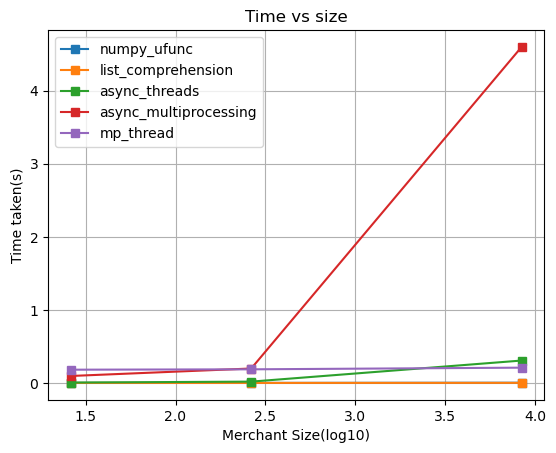

In [171]:
size_1 = 10**size_1
plt.plot(size_1,numpy_ufunc_time,'-s')
plt.plot(size_1,list_comprehension_time,'-s')
plt.plot(size_1,async_threads_time,'-s')
plt.plot(size_1,async_multiprocessing_time,'-s')
plt.plot(size_1,mp_thread_time,'-s')
plt.grid()
plt.xlabel("Merchant Size(log10)")
plt.ylabel("Time taken(s)")
legend = ["numpy_ufunc",'list_comprehension','async_threads','async_multiprocessing','mp_thread']
plt.legend(legend)
plt.title("Time vs size")
plt.show()

It can be seen from the above graph, that our function <b>list_comprehension()</b> is the fastest